# Comparison of methods

In this notebook the tables of the different evaluations are put together to compare them and to obtain the best method. A comparative graph is generated for clarity.

## Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import jinja2 


import os
from pathlib import Path

## Data

Read saved evaluation tables. 

In [2]:
path_to_eval_csvs = Path('..\data\model-evaluation-results')

# read all evaluations per model
sis_eval = pd.read_csv(os.path.join(path_to_eval_csvs,'ci_SIS_evaluation_w8_target_y'), index_col=0)
poly_1_eval = pd.read_csv(os.path.join(path_to_eval_csvs, 'POLY-evaluation-degree-1'), index_col=0)
arima_eval = pd.read_csv(os.path.join(path_to_eval_csvs, 'ci_ARIMA_(2, 1, 5)_evaluation.csv'), index_col=0)
rnn_eval = pd.read_csv(os.path.join(path_to_eval_csvs, 'best-rnn-evaluation'), index_col=0)

Se separan las evaluaciones según la métrica, creando una tabla para comparar el RMSLE, otra para MAE, RMSE y MAPE.

In [3]:
# create a df made of the evaluation for one of the metrics for each model
def metric_df(metric):
    metric_df = pd.DataFrame({'SIS': sis_eval.loc[metric],
                         'Regression': poly_1_eval.loc[metric],
                         'ARIMA': arima_eval.loc[metric],
                         'RNN': rnn_eval.loc[metric]})

    metric_df.rename(columns={f'{model_name}':f'{model_name} ({metric})' for model_name in metric_df.columns}, inplace=True)
    
    return metric_df

# plot metric evolution
def plot_metric(metric):
    metric_df(metric).plot(figsize=(10,5))
    plt.title(f'{metric} evolution')
    plt.show()

Finally, the evolution of each metric per model as the time horizon increases is shown in a graph composed of 4 subgraphs. 

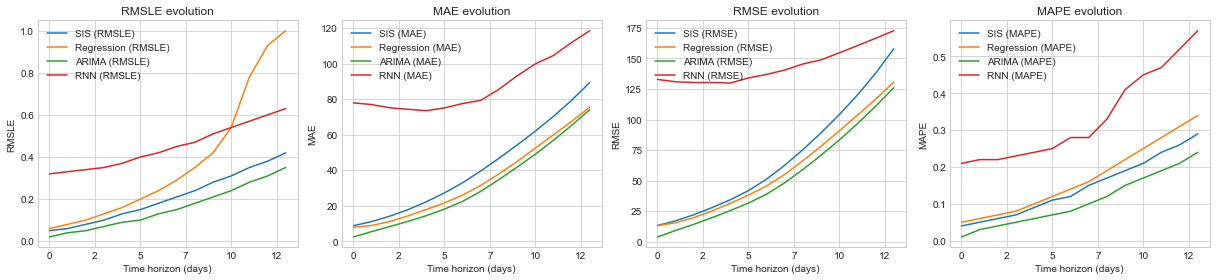

In [4]:
fig, axs = plt.subplots(1,4, figsize=(17, 4), tight_layout=True)
for metric, i in zip(['RMSLE', 'MAE', 'RMSE', 'MAPE'], range(0,4)):
    metric_df(metric).plot(ax=axs[i])
    axs[i].set_title(f'{metric} evolution')
    axs[i].legend(loc='upper left')
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel('Time horizon (days)')

    # change each x labels to integer values
    x_labels = [int(x) for x in axs[i].get_xticks()]
    axs[i].set_xticklabels(x_labels)

- All the metrics increase as the time horizon increases for all the models, which is reasonable, since the farther the future point is from the known observations, the greater the uncertainty. 

- It can be seen that the best model for any metric is the ARIMA(2,1,5). The RNN considered is incapable of correctly capturing the dynamics of the virus, which is manifested by generating predictions that are insufficiently accurate. The SIS model and linear regression follow a similar evolution except for the RMSLE, when the linear regression model increases drastically from time horizon 8 onwards. This may be because the series studied does not verify the hypotheses of the SIS model and is unable to provide parameters with epidemiological significance. Consequently, the model has no epidemiological interpretation but becomes a mere regression adjustment. 

- Finally, it should be recalled that none of the models studied verifies the initial hypotheses. Therefore, the results could be improved by studying another type of method.

The following code reads the folder images for each model and compares the predictions at horizons 1, 7 and 14. 

In [45]:
image_forecasts_path = Path('..\data\\analysis-data')
sis_images = [f'sis-forecast-h{i}.png' for i in [1,7,14]]
arima_images = [f'arima-forecast-h{i}.png' for i in [1,7,14]]


def plot_forecasts_images(files_name, image_forecasts_path=image_forecasts_path):
    fig, axs = plt.subplots(1,3, figsize=(17, 4), tight_layout=True)

    for file_name, j in zip(files_name, range(0,3)):
        # import image as array
        forecasts_img = mpimg.imread(os.path.join(image_forecasts_path, file_name))

        axs[j].imshow(forecasts_img)
        axs[j].axis('off')

    model_name = file_name.split('-')[0].upper()
    plt.suptitle(f'{model_name} forecasts for h=1, 7, 14', y=0.85)
    plt.show()

plot_forecasts_images(sis_images)
# plot_forecasts_images(arima_images)

Below is the numerical evolution of the evaluations and the lowest at each step is underlined.

In [68]:
for metric in sis_eval.index:
    evaluation = metric_df(metric).round(2)
    # highlight min per column
    display(evaluation.style.highlight_min(axis=1))
    # change index name from f'step_{i}' to f'h={i}'
    # evaluation.index = [f'h={i}' for i in range(1, len(evaluation)+1)]
    # evaluation to latex 
    # latex = evaluation.to_latex()
    # print(latex)


,SIS (RMSLE),Regression (RMSLE),ARIMA (RMSLE),RNN (RMSLE)
step_1,0.050000,0.060000,0.020000,0.320000
step_2,0.060000,0.080000,0.040000,0.330000
step_3,0.080000,0.100000,0.050000,0.340000
step_4,0.100000,0.130000,0.070000,0.350000
step_5,0.130000,0.160000,0.090000,0.370000
step_6,0.150000,0.200000,0.100000,0.400000
step_7,0.180000,0.240000,0.130000,0.420000
step_8,0.210000,0.290000,0.150000,0.450000
step_9,0.240000,0.350000,0.180000,0.470000
step_10,0.280000,0.420000,0.210000,0.510000


,SIS (MAE),Regression (MAE),ARIMA (MAE),RNN (MAE)
step_1,8.760000,7.870000,2.400000,77.870000
step_2,11.060000,8.860000,5.450000,76.940000
step_3,14.120000,11.110000,8.250000,75.120000
step_4,17.770000,14.280000,11.180000,74.290000
step_5,22.170000,17.860000,14.350000,73.470000
step_6,27.170000,21.530000,18.050000,75.020000
step_7,32.900000,25.940000,22.410000,77.520000
step_8,39.520000,31.400000,28.040000,79.300000
step_9,46.660000,37.850000,34.690000,85.520000
step_10,54.130000,44.850000,41.690000,93.070000


,SIS (RMSE),Regression (RMSE),ARIMA (RMSE),RNN (RMSE)
step_1,13.290000,13.160000,3.890000,132.830000
step_2,17.110000,15.540000,9.220000,130.950000
step_3,22.120000,19.710000,14.260000,130.330000
step_4,27.910000,25.190000,19.670000,130.320000
step_5,34.290000,31.380000,25.470000,129.890000
step_6,41.770000,38.130000,31.610000,134.020000
step_7,51.200000,45.640000,38.910000,136.960000
step_8,62.590000,55.070000,48.230000,140.510000
step_9,75.280000,66.300000,59.110000,145.460000
step_10,89.120000,78.180000,70.800000,148.840000


,SIS (MAPE),Regression (MAPE),ARIMA (MAPE),RNN (MAPE)
step_1,0.040000,0.050000,0.010000,0.210000
step_2,0.050000,0.060000,0.030000,0.220000
step_3,0.060000,0.070000,0.040000,0.220000
step_4,0.070000,0.080000,0.050000,0.230000
step_5,0.090000,0.100000,0.060000,0.240000
step_6,0.110000,0.120000,0.070000,0.250000
step_7,0.120000,0.140000,0.080000,0.280000
step_8,0.150000,0.160000,0.100000,0.280000
step_9,0.170000,0.190000,0.120000,0.330000
step_10,0.190000,0.220000,0.150000,0.410000
